# Ames Housing Project


## Project Challenge Statement

#### Goal: Predict the price of homes at sale for the Aimes Iowa Housing dataset. 

Two files used to build the model. 

- train_data_cleanna.csv -- this data contains all of the training data with no missing values and outliers
- test_data_cleanna.csv -- this data contains all of the testing data with no missing values and outlier

#### Prediction Files 
- LR_tt_submit.csv -- this file will be the baseline submisstion of Linear Regression Model with TransformedTargetRegressor()
- lasso_tt_submit.csv -- this file will be the tt submission using Lasso CV with TransformedTargetRegressor()
- ridge_tt_submit.csv -- this file will be the tt submission using Ridge CV with TransformedTargetRegressor()
- esn_tt_submit.csv -- this file will be the tt submission using ElasticNet CV with TransformedTargetRegressor()

## Table of Contents 

This Notebook is broken down into different sections for analysis purpose. The following links are connected to differenct section within the Notebook for simple navigation. 

### Contents:
- [Linear Tuning Regression Model](#Linear-Tuning-Regression-Model)
- [Lasso Tuning Model](#Lasso-Tuning-Model)
- [Ridge Tuning Model](#Ridge-Tuning-Model)
- [ElasticNet Tuning Model](#ElasticNet-Tuning-Model)

### Describtion 
In the previous Model Benchmarks Notebook, 4 models were built without standardizing the y variable. As we can see from the EDA, y variable, Sale Price is skew to the right. To standardize Y, in this notebook, I am going to use TransformedTargetRegressor() to standardize X and y. 

Note: TransformedTargetRegressor() takes arguments 
1. `regressor` = model, : model to perform transformation 
2. `func` = np.log, : transformation method 
3. `inverse_func` = np.exp : inverse transformation for output 

In [38]:
#Eliminate warnings 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [39]:
# Library imports
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, RFECV
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


np.random.seed(42)
%matplotlib inline

In [40]:
from functions import *

In [41]:
#import Data 
clean_train_data = pd.read_csv('../datasets/train_data_clean.csv')
clean_test_data = pd.read_csv('../datasets/test_data_clean.csv')

base_train_data = pd.read_csv('../datasets/train_data_cleanna.csv')
base_test_data = pd.read_csv('../datasets/test_data_cleanna.csv')

In [42]:
#Extract common values in X_train and X_test values for X Variables 
p_cols = ['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Garage Area', 'Wood Deck SF', 'Screen Porch', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_NAmes',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_StoneBr', 'Exterior 1st_BrkFace',
       'Garage Cond_Ex']

In [43]:
#Categorical Values for getting Dummy
X_dummy = ext_cat_features(base_train_data)

## Linear Tuning Regression Model 

### Fit Linear Regression Model For Prediction with X Y Standardization

In [44]:
X = pd.get_dummies(base_train_data, columns = X_dummy).drop(columns = ['Unnamed: 0', 'Id','PID', 'SalePrice'])
y = base_train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [45]:
tt = TransformedTargetRegressor(regressor = LinearRegression(),
                                func=np.log, inverse_func=np.exp)
tt.fit(X_train[p_cols], y_train)

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
              inverse_func=<ufunc 'exp'>,
              regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
              transformer=None)

In [46]:
print('train score', tt.score(X_train[p_cols], y_train))
print('test score', tt.score(X_test[p_cols], y_test))

train score 0.916995787903919
test score 0.922934358669498


Text(0.5, 1.0, 'Y Test hat vs Y Test')

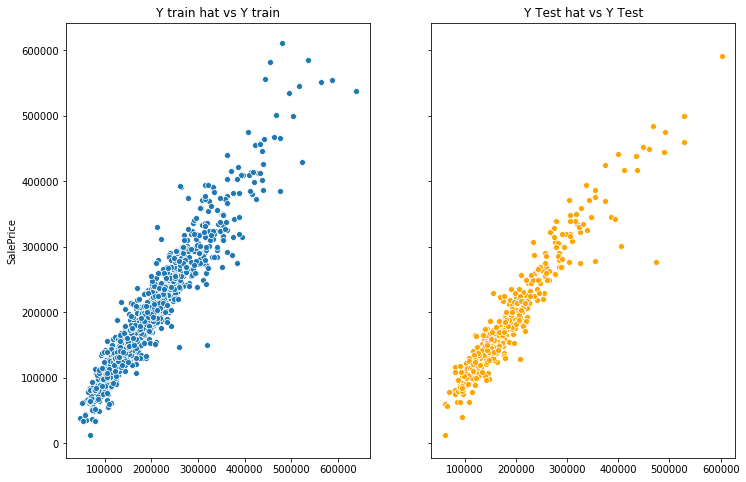

In [91]:
#Residual Plot of y_prect and y_train
y_train_prect = tt.predict(X_train[p_cols])
y_test_prect = tt.predict(X_test[p_cols])
#plotting scatter plot for y_train predict and y_train
fig, axes = plt.subplots(1, 2, sharey='row', figsize = (12,8))
ax1 = sns.scatterplot(x = y_train_prect, 
                y = y_train, 
                ax = axes[0])
ax1.set_title("Y train hat vs Y train")
ax2 = sns.scatterplot(x = y_test_prect, y = y_test, ax = axes[1], color = 'orange')
ax2.set_title("Y Test hat vs Y Test")

In [47]:
#Manipulate Test data frame for prediction
X_predict = pd.get_dummies(base_test_data, columns = X_dummy).drop(columns = ['Unnamed: 0', 'Id','PID'])

In [48]:
tt_predict = tt.predict(X_predict[p_cols])
tt_predict.shape

(879,)

In [49]:
#save df procedure
id_df = clean_test_data[['Id']]
ttr_firstsub_test_predict = pd.DataFrame(tt_predict, columns = ['SalePrice'])
df = id_df.join(ttr_firstsub_test_predict)
df.columns = ['Id', "SalePrice"]
df = df.set_index('Id')
df.shape

(879, 1)

In [50]:
df.to_csv('../datasets/ttr_first_submit.csv')

## Lasso Tuning Model

### Polynomial Transformation with Lasso Model X Y Standardization

In [51]:
X = pd.get_dummies(base_train_data, columns = X_dummy).drop(columns = ['Unnamed: 0', 'Id','PID', 'SalePrice'])
y = base_train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [52]:
#Lasso pipeline 
lasso = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ss', StandardScaler()),
    ('tt', TransformedTargetRegressor(regressor = LassoCV(), func=np.log, inverse_func=np.exp))
])

In [53]:
lasso.fit(X_train[p_cols], y_train)
lasso_predict = lasso.predict(X_test[p_cols])
print("train score", lasso.score(X_train[p_cols], y_train))
print('test score', lasso.score(X_test[p_cols], y_test))
print("R2 score", r2_score(lasso_predict, y_test));

train score 0.9392577735894638
test score 0.9326770414104285
R2 score 0.9253515412291191


Text(0.5, 1.0, 'Y Test hat vs Y Test')

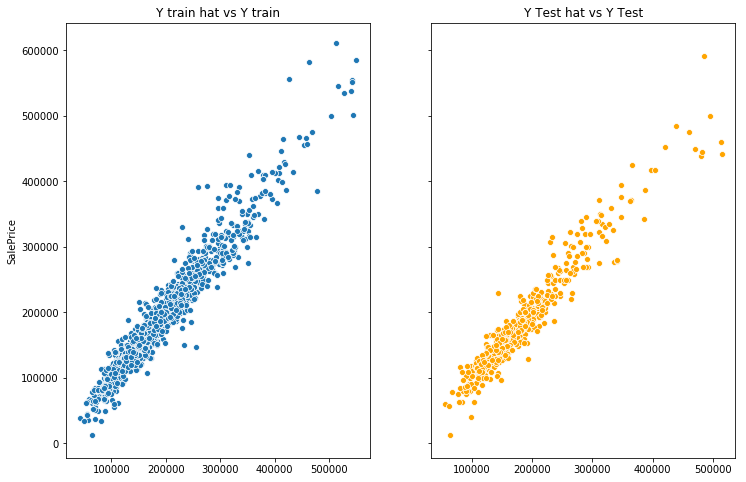

In [92]:
#Residual Plot of y_prect and y_train
y_train_prect = lasso.predict(X_train[p_cols])
y_test_prect = lasso.predict(X_test[p_cols])
#plotting scatter plot for y_train predict and y_train
fig, axes = plt.subplots(1, 2, sharey='row', figsize = (12,8))
ax1 = sns.scatterplot(x = y_train_prect, 
                y = y_train, 
                ax = axes[0])
ax1.set_title("Y train hat vs Y train")
ax2 = sns.scatterplot(x = y_test_prect, y = y_test, ax = axes[1], color = 'orange')
ax2.set_title("Y Test hat vs Y Test")

In [54]:
#save df procedure
id_df = clean_test_data[['Id']]

lasso_firstsub_test_predict = lasso.predict(X_predict[p_cols])

lasso_firstsub_test_predict = pd.DataFrame(lasso_firstsub_test_predict, columns = ['SalePrice'])

df = id_df.join(lasso_firstsub_test_predict)

df.columns = ['Id', "SalePrice"]

df = df.set_index('Id')

df.to_csv('../datasets/lasso_tt_submit.csv')

## Ridge Tuning Model

### Polynomial Transformation with Ridge Model and X Y Standardization

In [55]:
X = pd.get_dummies(base_train_data, columns = X_dummy).drop(columns = ['Unnamed: 0', 'Id','PID', 'SalePrice'])
y = base_train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [56]:
#Lasso pipeline 
ridge = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ss', StandardScaler()),
    ('tt', TransformedTargetRegressor(regressor = RidgeCV(), func=np.log, inverse_func=np.exp))
])

In [57]:
ridge.fit(X_train[p_cols], y_train)
ridge_predict = ridge.predict(X_test[p_cols])
print("train score", ridge.score(X_train[p_cols], y_train))
print('test score', ridge.score(X_test[p_cols], y_test))
print("R2 score", r2_score(ridge_predict, y_test));

train score 0.9474560105437301
test score 0.9041678203491119
R2 score 0.8945915127673574


Text(0.5, 1.0, 'Y Test hat vs Y Test')

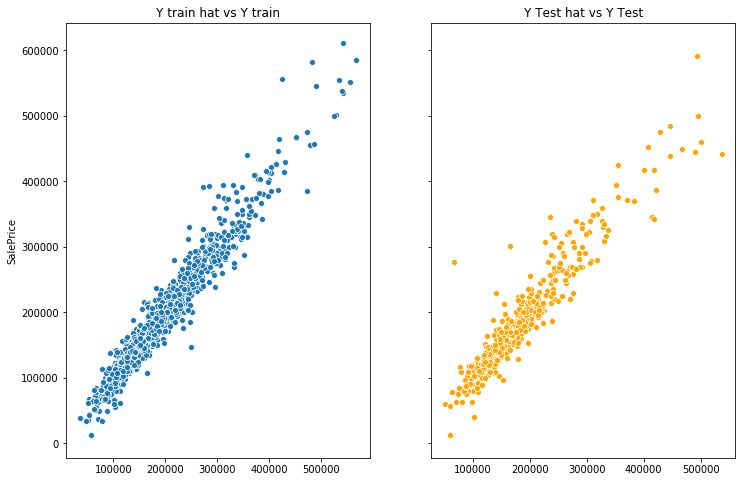

In [94]:
#Residual Plot of y_prect and y_train
y_train_prect = ridge.predict(X_train[p_cols])
y_test_prect = ridge.predict(X_test[p_cols])
#ploridgeing scaridgeer plot for y_train predict and y_train
fig, axes = plt.subplots(1, 2, sharey='row', figsize = (12,8))
ax1 = sns.scatterplot(x = y_train_prect, 
                y = y_train, 
                ax = axes[0])
ax1.set_title("Y train hat vs Y train")
ax2 = sns.scatterplot(x = y_test_prect, y = y_test, ax = axes[1], color = 'orange')
ax2.set_title("Y Test hat vs Y Test")

In [58]:
#save df procedure
id_df = clean_test_data[['Id']]

ridge_firstsub_test_predict = ridge.predict(X_predict[p_cols])

ridge_firstsub_test_predict = pd.DataFrame(ridge_firstsub_test_predict, columns = ['SalePrice'])

df = id_df.join(ridge_firstsub_test_predict)

df.columns = ['Id', "SalePrice"]

df = df.set_index('Id')

df.to_csv('../datasets/ridge_tt_submit.csv')


## ElasticNet Tuning Model

### Polynomial Transformation with ElasticNet Model 

In [59]:
X = pd.get_dummies(base_train_data, columns = X_dummy).drop(columns = ['Unnamed: 0', 'Id','PID', 'SalePrice'])
y = base_train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [60]:
#Lasso pipeline 
esn = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ss', StandardScaler()),
    ('tt', TransformedTargetRegressor(regressor = ElasticNetCV(), func=np.log, inverse_func=np.exp))
])

In [61]:
esn.fit(X_train[p_cols], y_train)
esn_predict = esn.predict(X_test[p_cols])
print("train score", esn.score(X_train[p_cols], y_train))
print('test score', esn.score(X_test[p_cols], y_test))
print("R2 score", r2_score(esn_predict, y_test));

train score 0.9391543168913411
test score 0.9330187165639208
R2 score 0.9258804643085847


Text(0.5, 1.0, 'Y Test hat vs Y Test')

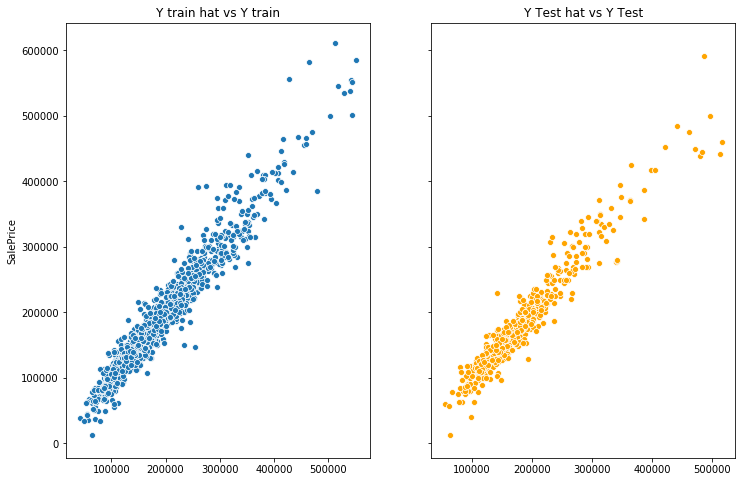

In [95]:
#Residual Plot of y_prect and y_train
y_train_prect = esn.predict(X_train[p_cols])
y_test_prect = esn.predict(X_test[p_cols])
#plotting scatter plot for y_train predict and y_train
fig, axes = plt.subplots(1, 2, sharey='row', figsize = (12,8))
ax1 = sns.scatterplot(x = y_train_prect, 
                y = y_train, 
                ax = axes[0])
ax1.set_title("Y train hat vs Y train")
ax2 = sns.scatterplot(x = y_test_prect, y = y_test, ax = axes[1], color = 'orange')
ax2.set_title("Y Test hat vs Y Test")

In [62]:
#save df procedure
id_df = clean_test_data[['Id']]

esn_firstsub_test_predict = esn.predict(X_predict[p_cols])

esn_firstsub_test_predict = pd.DataFrame(esn_firstsub_test_predict, columns = ['SalePrice'])

df = id_df.join(esn_firstsub_test_predict)

df.columns = ['Id', "SalePrice"]

df = df.set_index('Id')

df.to_csv('../datasets/esn_tt_submit.csv')

### Conclusion 

Above all models, Ridge Model with polynomial transformation and TransformedTargetRegressor gives me the lowest MSE. 
Thus, the following analysis will be base on the Ridge Model. 